<a href="https://colab.research.google.com/github/MariaZharova/recsys_internship/blob/main/SASRec_with_itemEmb_v4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip install recommenders scrapbook

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 339 kB 20.8 MB/s 
     |████████████████████████████████| 61 kB 7.9 MB/s 
     |████████████████████████████████| 636 kB 62.6 MB/s 
     |████████████████████████████████| 12.4 MB 32.4 MB/s 
     |████████████████████████████████| 310 kB 68.7 MB/s 
     |████████████████████████████████| 355 kB 63.7 MB/s 
     |████████████████████████████████| 197 kB 72.2 MB/s 
     |████████████████████████████████| 4.7 MB 59.9 MB/s 
     |████████████████████████████████| 11.8 MB 73.3 MB/s 
     |████████████████████████████████| 390 kB 56.6 MB/s 
     |████████████████████████████████| 6.6 MB 52.5 MB/s 
     |████████████████████████████████| 120 kB 17.4 MB/s 
     |████████████████████████████████| 1.6 MB 49.5 MB/s 
     |████████████████████████████████| 71 kB 162 kB/s 
     |████████████████████████████████| 106 kB 75.7 MB/s 
  Created wheel for lightfm: file

In [2]:
import warnings
warnings.filterwarnings("ignore")

import re
import sys
import os
import scrapbook as sb
from tempfile import TemporaryDirectory
import numpy as np
import pandas as pd 

from collections import defaultdict
import tensorflow as tf
tf.get_logger().setLevel('ERROR') # only show error messages
from scipy.sparse import csr_matrix, load_npz

from recommenders.utils.timer import Timer
from recommenders.datasets.split_utils import filter_k_core

# Transformer Based Models
#from recommenders.models.sasrec.model import SASREC

# Sampler for sequential prediction
from recommenders.models.sasrec.sampler import WarpSampler
from recommenders.models.sasrec.util import SASRecDataSet

In [3]:
import random
from tqdm import tqdm

from recommenders.models.sasrec.model import Encoder
from recommenders.models.sasrec.model import LayerNormalization

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
class SASREC(tf.keras.Model):
    """SAS Rec model
    Self-Attentive Sequential Recommendation Using Transformer
    :Citation:
        Wang-Cheng Kang, Julian McAuley (2018), Self-Attentive Sequential
        Recommendation. Proceedings of IEEE International Conference on
        Data Mining (ICDM'18)
        Original source code from nnkkmto/SASRec-tf2,
        https://github.com/nnkkmto/SASRec-tf2
    """

    def __init__(self, **kwargs):
        """Model initialization.
        Args:
            item_num (int): Number of items in the dataset.
            seq_max_len (int): Maximum number of items in user history.
            num_blocks (int): Number of Transformer blocks to be used.
            embedding_dim (int): Item embedding dimension.
            attention_dim (int): Transformer attention dimension.
            conv_dims (list): List of the dimensions of the Feedforward layer.
            dropout_rate (float): Dropout rate.
            l2_reg (float): Coefficient of the L2 regularization.
            num_neg_test (int): Number of negative examples used in testing.
        """
        super(SASREC, self).__init__()

        self.item_num = kwargs.get("item_num", None)
        self.seq_max_len = kwargs.get("seq_max_len", 100)
        self.num_blocks = kwargs.get("num_blocks", 2)
        self.embedding_dim = kwargs.get("embedding_dim", 100)
        self.attention_dim = kwargs.get("attention_dim", 100)
        self.attention_num_heads = kwargs.get("attention_num_heads", 1)
        self.conv_dims = kwargs.get("conv_dims", [100, 100])
        self.dropout_rate = kwargs.get("dropout_rate", 0.5)
        self.l2_reg = kwargs.get("l2_reg", 0.0)
        self.num_neg_test = kwargs.get("num_neg_test", 100)

        self.item_embedding_layer = tf.keras.layers.Embedding(
            self.item_num + 1,
            self.embedding_dim,
            name="item_embeddings",
            mask_zero=True,
            embeddings_regularizer=tf.keras.regularizers.L2(self.l2_reg),
        )

        self.positional_embedding_layer = tf.keras.layers.Embedding(
            self.seq_max_len,
            self.embedding_dim,
            name="positional_embeddings",
            mask_zero=False,
            embeddings_regularizer=tf.keras.regularizers.L2(self.l2_reg),
        )
        self.dropout_layer = tf.keras.layers.Dropout(self.dropout_rate)
        self.encoder = Encoder(
            self.num_blocks,
            self.seq_max_len,
            self.embedding_dim,
            self.attention_dim,
            self.attention_num_heads,
            self.conv_dims,
            self.dropout_rate,
        )
        self.mask_layer = tf.keras.layers.Masking(mask_value=0)
        self.layer_normalization = LayerNormalization(
            self.seq_max_len, self.embedding_dim, 1e-08
        )

    def embedding(self, input_seq):
        """Compute the sequence and positional embeddings.
        Args:
            input_seq (tf.Tensor): Input sequence
        Returns:
            tf.Tensor, tf.Tensor:
            - Sequence embeddings.
            - Positional embeddings.
        """

        seq_embeddings = self.item_embedding_layer(input_seq)
        seq_embeddings = seq_embeddings * (self.embedding_dim ** 0.5)

        # FIXME
        positional_seq = tf.expand_dims(tf.range(tf.shape(input_seq)[1]), 0)
        positional_seq = tf.tile(positional_seq, [tf.shape(input_seq)[0], 1])
        positional_embeddings = self.positional_embedding_layer(positional_seq)

        return seq_embeddings, positional_embeddings

    def call(self, x, training):
        """Model forward pass.
        Args:
            x (tf.Tensor): Input tensor.
            training (tf.Tensor): Training tensor.
        Returns:
            tf.Tensor, tf.Tensor, tf.Tensor:
            - Logits of the positive examples.
            - Logits of the negative examples.
            - Mask for nonzero targets
        """

        input_seq = x["input_seq"]
        pos = x["positive"]
        neg = x["negative"]

        mask = tf.expand_dims(tf.cast(tf.not_equal(input_seq, 0), tf.float32), -1)
        seq_embeddings, positional_embeddings = self.embedding(input_seq)

        # add positional embeddings
        seq_embeddings += positional_embeddings

        # dropout
        seq_embeddings = self.dropout_layer(seq_embeddings)

        # masking
        seq_embeddings *= mask

        # --- ATTENTION BLOCKS ---
        seq_attention = seq_embeddings
        seq_attention = self.encoder(seq_attention, training, mask)
        seq_attention = self.layer_normalization(seq_attention)  # (b, s, d)

        # --- PREDICTION LAYER ---
        # user's sequence embedding
        pos = self.mask_layer(pos)
        neg = self.mask_layer(neg)

        pos = tf.reshape(pos, [tf.shape(input_seq)[0] * self.seq_max_len])
        neg = tf.reshape(neg, [tf.shape(input_seq)[0] * self.seq_max_len])
        pos_emb = self.item_embedding_layer(pos)
        neg_emb = self.item_embedding_layer(neg)
        seq_emb = tf.reshape(
            seq_attention,
            [tf.shape(input_seq)[0] * self.seq_max_len, self.embedding_dim],
        )  # (b*s, d)

        pos_logits = tf.reduce_sum(pos_emb * seq_emb, -1)
        neg_logits = tf.reduce_sum(neg_emb * seq_emb, -1)

        pos_logits = tf.expand_dims(pos_logits, axis=-1)  # (bs, 1)
        # pos_prob = tf.keras.layers.Dense(1, activation='sigmoid')(pos_logits)  # (bs, 1)

        neg_logits = tf.expand_dims(neg_logits, axis=-1)  # (bs, 1)
        # neg_prob = tf.keras.layers.Dense(1, activation='sigmoid')(neg_logits)  # (bs, 1)

        # output = tf.concat([pos_logits, neg_logits], axis=0)

        # masking for loss calculation
        istarget = tf.reshape(
            tf.cast(tf.not_equal(pos, 0), dtype=tf.float32),
            [tf.shape(input_seq)[0] * self.seq_max_len],
        )

        return pos_logits, neg_logits, istarget

    def predict(self, inputs):
        """Returns the logits for the test items.
        Args:
            inputs (tf.Tensor): Input tensor.
        Returns:
             tf.Tensor: Output tensor.
        """
        training = False
        input_seq = inputs["input_seq"]
        candidate = inputs["candidate"]

        mask = tf.expand_dims(tf.cast(tf.not_equal(input_seq, 0), tf.float32), -1)
        seq_embeddings, positional_embeddings = self.embedding(input_seq)
        seq_embeddings += positional_embeddings
        # seq_embeddings = self.dropout_layer(seq_embeddings)
        seq_embeddings *= mask
        seq_attention = seq_embeddings
        seq_attention = self.encoder(seq_attention, training, mask)
        seq_attention = self.layer_normalization(seq_attention)  # (b, s, d)
        seq_emb = tf.reshape(
            seq_attention,
            [tf.shape(input_seq)[0] * self.seq_max_len, self.embedding_dim],
        )  # (b*s, d)
        candidate_emb = self.item_embedding_layer(candidate)  # (b, s, d)
        candidate_emb = tf.transpose(candidate_emb, perm=[0, 2, 1])  # (b, d, s)

        test_logits = tf.matmul(seq_emb, candidate_emb)
        # (200, 100) * (1, 101, 100)'

        test_logits = tf.reshape(
            test_logits,
            [tf.shape(input_seq)[0], self.seq_max_len, 1 + self.num_neg_test],
        )  # (1, 200, 101)
        test_logits = test_logits[:, -1, :]  # (1, 101)
        return test_logits

    def loss_function(self, pos_logits, neg_logits, istarget):
        """Losses are calculated separately for the positive and negative
        items based on the corresponding logits. A mask is included to
        take care of the zero items (added for padding).
        Args:
            pos_logits (tf.Tensor): Logits of the positive examples.
            neg_logits (tf.Tensor): Logits of the negative examples.
            istarget (tf.Tensor): Mask for nonzero targets.
        Returns:
            float: Loss.
        """

        pos_logits = pos_logits[:, 0]
        neg_logits = neg_logits[:, 0]

        # ignore padding items (0)
        # istarget = tf.reshape(
        #     tf.cast(tf.not_equal(self.pos, 0), dtype=tf.float32),
        #     [tf.shape(self.input_seq)[0] * self.seq_max_len],
        # )
        # for logits
        loss = tf.reduce_sum(
            -tf.math.log(tf.math.sigmoid(pos_logits) + 1e-24) * istarget
            - tf.math.log(1 - tf.math.sigmoid(neg_logits) + 1e-24) * istarget
        ) / tf.reduce_sum(istarget)

        # for probabilities
        # loss = tf.reduce_sum(
        #         - tf.math.log(pos_logits + 1e-24) * istarget -
        #         tf.math.log(1 - neg_logits + 1e-24) * istarget
        # ) / tf.reduce_sum(istarget)
        reg_loss = tf.compat.v1.losses.get_regularization_loss()
        # reg_losses = tf.compat.v1.get_collection(tf.compat.v1.GraphKeys.REGULARIZATION_LOSSES)
        # loss += sum(reg_losses)
        loss += reg_loss

        return loss

    def create_combined_dataset(self, u, seq, pos, neg):
        """
        function to create model inputs from sampled batch data.
        This function is used only during training.
        """
        inputs = {}
        seq = tf.keras.preprocessing.sequence.pad_sequences(
            seq, padding="pre", truncating="pre", maxlen=self.seq_max_len
        )
        pos = tf.keras.preprocessing.sequence.pad_sequences(
            pos, padding="pre", truncating="pre", maxlen=self.seq_max_len
        )
        neg = tf.keras.preprocessing.sequence.pad_sequences(
            neg, padding="pre", truncating="pre", maxlen=self.seq_max_len
        )

        inputs["users"] = np.expand_dims(np.array(u), axis=-1)
        inputs["input_seq"] = seq
        inputs["positive"] = pos
        inputs["negative"] = neg

        target = np.concatenate(
            [
                np.repeat(1, seq.shape[0] * seq.shape[1]),
                np.repeat(0, seq.shape[0] * seq.shape[1]),
            ],
            axis=0,
        )
        target = np.expand_dims(target, axis=-1)
        return inputs, target

    """def train(self, dataset, sampler, **kwargs):
        
        #High level function for model training as well as
        #evaluation on the validation and test dataset
        
        num_epochs = kwargs.get("num_epochs", 10)
        batch_size = kwargs.get("batch_size", 128)
        lr = kwargs.get("learning_rate", 0.001)
        val_epoch = kwargs.get("val_epoch", 5)

        num_steps = int(len(dataset.user_train) / batch_size)

        optimizer = tf.keras.optimizers.Adam(
            learning_rate=lr, beta_1=0.9, beta_2=0.999, epsilon=1e-7
        )

        loss_function = self.loss_function

        train_loss = tf.keras.metrics.Mean(name="train_loss")

        train_step_signature = [
            {
                "users": tf.TensorSpec(shape=(None, 1), dtype=tf.int64),
                "input_seq": tf.TensorSpec(
                    shape=(None, self.seq_max_len), dtype=tf.int64
                ),
                "positive": tf.TensorSpec(
                    shape=(None, self.seq_max_len), dtype=tf.int64
                ),
                "negative": tf.TensorSpec(
                    shape=(None, self.seq_max_len), dtype=tf.int64
                ),
            },
            tf.TensorSpec(shape=(None, 1), dtype=tf.int64),
        ]

        @tf.function(input_signature=train_step_signature)
        def train_step(inp, tar):
            with tf.GradientTape() as tape:
                pos_logits, neg_logits, loss_mask = self(inp, training=True)
                loss = loss_function(pos_logits, neg_logits, loss_mask)

            gradients = tape.gradient(loss, self.trainable_variables)
            #gradients = [(tf.clip_by_value(grad, -1.0, 1.0)) for grad in gradients]
            optimizer.apply_gradients(zip(gradients, self.trainable_variables))

            train_loss(loss)
            return loss

        T = 0.0
        t0 = Timer()
        t0.start()

        for epoch in range(1, num_epochs + 1):

            WATCH_LOSS = 0
            counter = 0
            step_loss = []
            train_loss.reset_states()
            for step in tqdm(
                range(num_steps), total=num_steps, ncols=70, leave=False, unit="b"
            ):

                u, seq, pos, neg = sampler.next_batch()

                inputs, target = self.create_combined_dataset(u, seq, pos, neg)

                loss = train_step(inputs, target)
                step_loss.append(loss)
                WATCH_LOSS += loss
                counter += 1
            
            print(f"\nIn {epoch} epoch the LOSS is {WATCH_LOSS/counter}")
            # self.save

            if epoch % val_epoch == 0:
                t0.stop()
                t1 = t0.interval
                T += t1
                print("Evaluating...")
                t_test = self.evaluate(dataset)
                t_valid = self.evaluate_valid(dataset)
                print(
                    f"\nepoch: {epoch}, time: {T}, valid (NDCG@10: {t_valid[0]}, HR@10: {t_valid[1]})"
                )
                print(
                    f"epoch: {epoch}, time: {T},  test (NDCG@10: {t_test[0]}, HR@10: {t_test[1]})"
                )
                t0.start()

            if epoch == num_epochs:
                t0.stop()
                t1 = t0.interval
                T += t1
                print("Getting user's embeddings...")
                user_embeddings = self.get_all_user_embeddings(dataset)
                print("Nice:)")
                t0.start()

        t_test = self.evaluate(dataset)
        print(f"\nepoch: {epoch}, test (NDCG@10: {t_test[0]}, HR@10: {t_test[1]})")

        return t_test, user_embeddings"""

    def evaluate(self, dataset):
        """
        Evaluation on the test users (users with at least 3 items)
        """
        usernum = dataset.usernum
        itemnum = dataset.itemnum
        train = dataset.user_train  # removing deepcopy
        valid = dataset.user_valid
        test = dataset.user_test

        NDCG = 0.0
        HT = 0.0
        valid_user = 0.0

        if usernum > 100:
            users = random.sample(range(1, usernum + 1), 100)
        else:
            users = range(1, usernum + 1)

        for u in tqdm(users, ncols=70, leave=False, unit="b"):

            if len(train[u]) < 1 or len(test[u]) < 1:
                continue

            seq = np.zeros([self.seq_max_len], dtype=np.int32)
            idx = self.seq_max_len - 1
            seq[idx] = valid[u][0]
            idx -= 1
            for i in reversed(train[u]):
                seq[idx] = i
                idx -= 1
                if idx == -1:
                    break
            rated = set(train[u])
            rated.add(0)
            item_idx = [test[u][0]]
            for _ in range(self.num_neg_test):
                t = np.random.randint(1, itemnum + 1)
                while t in rated:
                    t = np.random.randint(1, itemnum + 1)
                item_idx.append(t)

            inputs = {}
            inputs["user"] = np.expand_dims(np.array([u]), axis=-1)
            inputs["input_seq"] = np.array([seq])
            inputs["candidate"] = np.array([item_idx])

            # inverse to get descending sort
            predictions = -1.0 * self.predict(inputs)
            predictions = np.array(predictions)
            predictions = predictions[0]

            rank = predictions.argsort().argsort()[0]

            valid_user += 1

            if rank < 10:
                NDCG += 1 / np.log2(rank + 2)
                HT += 1

        return NDCG / valid_user, HT / valid_user

    def evaluate_valid(self, dataset):
        """
        Evaluation on the validation users
        """
        usernum = dataset.usernum
        itemnum = dataset.itemnum
        train = dataset.user_train  # removing deepcopy
        valid = dataset.user_valid

        NDCG = 0.0
        valid_user = 0.0
        HT = 0.0
        if usernum > 100:
            users = random.sample(range(1, usernum + 1), 100)
        else:
            users = range(1, usernum + 1)

        for u in tqdm(users, ncols=70, leave=False, unit="b"):
            if len(train[u]) < 1 or len(valid[u]) < 1:
                continue

            seq = np.zeros([self.seq_max_len], dtype=np.int32)
            idx = self.seq_max_len - 1
            for i in reversed(train[u]):
                seq[idx] = i
                idx -= 1
                if idx == -1:
                    break

            rated = set(train[u])
            rated.add(0)
            item_idx = [valid[u][0]]
            for _ in range(self.num_neg_test):
                t = np.random.randint(1, itemnum + 1)
                while t in rated:
                    t = np.random.randint(1, itemnum + 1)
                item_idx.append(t)

            inputs = {}
            inputs["user"] = np.expand_dims(np.array([u]), axis=-1)
            inputs["input_seq"] = np.array([seq])
            inputs["candidate"] = np.array([item_idx])

            # predictions = -model.predict(sess, [u], [seq], item_idx)
            predictions = -1.0 * self.predict(inputs)
            predictions = np.array(predictions)
            predictions = predictions[0]

            rank = predictions.argsort().argsort()[0]

            valid_user += 1

            if rank < 10:
                NDCG += 1 / np.log2(rank + 2)
                HT += 1

        return NDCG / valid_user, HT / valid_user

In [9]:
# create special data format for SAS
dataS = SASRecDataSet(filename='./drive/MyDrive/out_1808.txt', col_sep='\t')
# split into train, test and validation
dataS.split()

In [10]:
print(dataS.usernum)
print(dataS.itemnum)

431982
388607


In [17]:
# model variables
num_epochs = 50
batch_size = 200   #                                                         !!!
RANDOM_SEED = 100  # Set None for non-deterministic result
lr = 0.0001            # learning rate                                       !!!
maxlen = 50            # maximum sequence length for each user
num_blocks = 2         # number of transformer blocks
hidden_units = 100     # number of units in the attention calculation.       !!!
num_heads = 1          # number of attention heads
dropout_rate = 0.1     # dropout rate
l2_emb = 0.0           # L2 regularization coefficient                       !!!
num_neg_test = dataS.itemnum  # number of negative examples per positive example


In [18]:
# sample negative examples
sampler = WarpSampler(dataS.user_train, dataS.usernum, dataS.itemnum, batch_size=batch_size, maxlen=maxlen, n_workers=3)

In [19]:
model = SASREC(item_num=dataS.itemnum,
               seq_max_len=maxlen,
               num_blocks=num_blocks,
               embedding_dim=hidden_units,
               attention_dim=hidden_units,
               attention_num_heads=num_heads,
               dropout_rate=dropout_rate,
               conv_dims = [hidden_units, hidden_units],         ### !!!
               l2_reg=l2_emb,
               num_neg_test=num_neg_test)
#model_architecture = model.to_json()

In [20]:
# восстанавливаем модель
model.load_weights('./drive/MyDrive/model_epoch_10_loss_0.0415')

In [21]:
#model.save('my_model')
#new_model = tf.keras.models.load_model('my_model')
dataset = dataS
val_epoch = 20

num_steps = int(len(dataset.user_train) / batch_size)

optimizer = tf.keras.optimizers.Adam(
    learning_rate=lr, beta_1=0.9, beta_2=0.999, epsilon=1e-7
)

loss_function = model.loss_function

train_loss = tf.keras.metrics.Mean(name="train_loss")

train_step_signature = [
    {
        "users": tf.TensorSpec(shape=(None, 1), dtype=tf.int64),
        "input_seq": tf.TensorSpec(
            shape=(None, model.seq_max_len), dtype=tf.int64
        ),
        "positive": tf.TensorSpec(
            shape=(None, model.seq_max_len), dtype=tf.int64
        ),
        "negative": tf.TensorSpec(
            shape=(None, model.seq_max_len), dtype=tf.int64
        ),
    },
    tf.TensorSpec(shape=(None, 1), dtype=tf.int64),
]

@tf.function(input_signature=train_step_signature)
def train_step(inp, tar):
    with tf.GradientTape() as tape:
        pos_logits, neg_logits, loss_mask = model(inp, training=True)
        loss = loss_function(pos_logits, neg_logits, loss_mask)

    gradients = tape.gradient(loss, model.trainable_variables)
    #gradients = [(tf.clip_by_value(grad, -1.0, 1.0)) for grad in gradients]
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    train_loss(loss)
    return loss

T = 0.0
t0 = Timer()
t0.start()

for epoch in range(1, num_epochs + 1):

    WATCH_LOSS = 0
    counter = 0
    step_loss = []
    train_loss.reset_states()
    for step in tqdm(
        range(num_steps), total=num_steps, ncols=70, leave=False, unit="b"
    ):

        u, seq, pos, neg = sampler.next_batch()

        inputs, target = model.create_combined_dataset(u, seq, pos, neg)

        loss = train_step(inputs, target)
        step_loss.append(loss)
        WATCH_LOSS += loss.numpy()
        counter += 1
    
    print(f"\nIn {epoch} epoch the LOSS is {WATCH_LOSS/counter}")
    if epoch % val_epoch == 0:
        t0.stop()
        t1 = t0.interval
        T += t1
        print("Evaluating...")
        t_test = model.evaluate(dataset)
        t_valid = model.evaluate_valid(dataset)
        print(
            f"\nepoch: {epoch}, time: {T}, valid (NDCG@10: {t_valid[0]}, HR@10: {t_valid[1]})"
        )
        print(
            f"epoch: {epoch}, time: {T},  test (NDCG@10: {t_test[0]}, HR@10: {t_test[1]})"
        )
        t0.start()
    model.save_weights(f'./drive/MyDrive/ML/model_epoch_{epoch}_loss_{round(WATCH_LOSS/counter, 4)}')

#t_test = model.evaluate(dataset)
#print(f"\nepoch: {epoch}, test (NDCG@10: {t_test[0]}, HR@10: {t_test[1]})")


In 1 epoch the LOSS is 0.042486008704433344



In 2 epoch the LOSS is 0.04282974372322414



In 3 epoch the LOSS is 0.042687527983759556



In 4 epoch the LOSS is 0.042466855418556486



In 5 epoch the LOSS is 0.04280470688915766



In 6 epoch the LOSS is 0.04233286310730984



In 7 epoch the LOSS is 0.04234578718671566



In 8 epoch the LOSS is 0.041999958857597164



In 9 epoch the LOSS is 0.04234841087295563



In 10 epoch the LOSS is 0.04181225174859394



In 11 epoch the LOSS is 0.041826738979824446



In 12 epoch the LOSS is 0.0416503117461622



In 13 epoch the LOSS is 0.04175421056277694



In 14 epoch the LOSS is 0.04143154498184511



In 15 epoch the LOSS is 0.041247093223549525



In 16 epoch the LOSS is 0.04124882818735021



In 17 epoch the LOSS is 0.04100416945021784



In 18 epoch the LOSS is 0.04104656190363386



In 19 epoch the LOSS is 0.04089022102632446



In 20 epoch the LOSS is 0.040728619150496456
Evaluating...



epoch: 20, time: 1964.1055615050002, valid (NDCG@10: 0.05424999977116429, HR@10: 0.09)
epoch: 20, time: 1964.1055615050002,  test (NDCG@10: 0.03397582974654236, HR@10: 0.09)



In 21 epoch the LOSS is 0.040616155091730076



In 22 epoch the LOSS is 0.040553088188205896



In 23 epoch the LOSS is 0.040071562468322296



In 24 epoch the LOSS is 0.04033129744580246



In 25 epoch the LOSS is 0.04013312483252116



In 26 epoch the LOSS is 0.03995443520624917



In 27 epoch the LOSS is 0.0398225769057228



In 28 epoch the LOSS is 0.03979405619880429



In 29 epoch the LOSS is 0.03969056483905119



In 30 epoch the LOSS is 0.03986950745032224



In 31 epoch the LOSS is 0.03921432574695876



In 32 epoch the LOSS is 0.03937097424714584



In 33 epoch the LOSS is 0.03907290115717828



In 34 epoch the LOSS is 0.03893991875591213



In 35 epoch the LOSS is 0.039057667894722856



In 36 epoch the LOSS is 0.03891897730998636



In 37 epoch the LOSS is 0.03873689358017825



In 38 epoch the LOSS is 0.0385458118145515



In 39 epoch the LOSS is 0.03823544131699758



In 40 epoch the LOSS is 0.038696126383438105
Evaluating...



epoch: 40, time: 3920.4652327350004, valid (NDCG@10: 0.045699593885561864, HR@10: 0.1)
epoch: 40, time: 3920.4652327350004,  test (NDCG@10: 0.04353120927672563, HR@10: 0.1)



In 41 epoch the LOSS is 0.03832351388655613



In 42 epoch the LOSS is 0.03832798837690565



In 43 epoch the LOSS is 0.03815892651839326



In 44 epoch the LOSS is 0.03804090514264901



In 45 epoch the LOSS is 0.037789521646574176



In 46 epoch the LOSS is 0.037736895179696084



In 47 epoch the LOSS is 0.03793330368167026



In 48 epoch the LOSS is 0.03753065702390235



In 49 epoch the LOSS is 0.03760879906864976



In 50 epoch the LOSS is 0.03755127445843386


In [ ]:
t0.stop()
t1 = t0.interval
T += t1
print("Evaluating...")
t_test = model.evaluate(dataset)
t_valid = model.evaluate_valid(dataset)
print(f"\nepoch: {epoch}, time: {T}, valid (NDCG@10: {t_valid[0]}, HR@10: {t_valid[1]})")
print(f"epoch: {epoch}, time: {T},  test (NDCG@10: {t_test[0]}, HR@10: {t_test[1]})")
t0.start()

Evaluating...



epoch: 10, time: 1627.4020416029998, valid (NDCG@10: 0.04028772322057299, HR@10: 0.09)
epoch: 10, time: 1627.4020416029998,  test (NDCG@10: 0.04205220607527929, HR@10: 0.09)


### Эмбеды объектов 

In [ ]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

In [ ]:
start = 0
limit = dataS.itemnum // 39
delta = 1
inp_seq = tf.reshape(
    tf.range(start, limit, delta), (limit, 1), name=None
)
item_embeddings = model.embedding(inp_seq)[0]
#inp_seq

In [ ]:
item_embeddings = tf.reshape(item_embeddings, (limit, 100), name=None)
np.save('./drive/MyDrive/ML/item_embeddings.npy', item_embeddings)

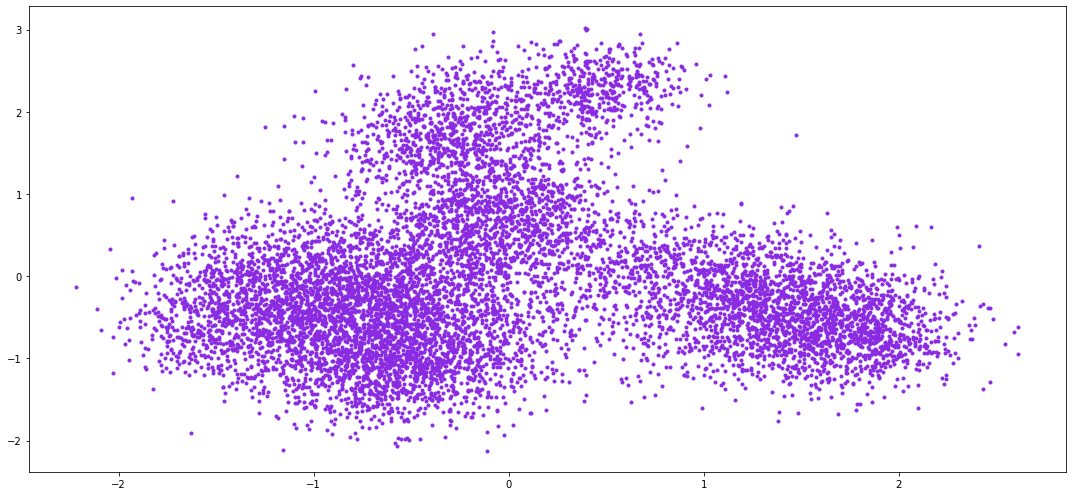

In [ ]:
pca = PCA(n_components=2, whiten=True) 
X_pca = pca.fit_transform(item_embeddings)

plt.rcParams["figure.figsize"] = [15.00, 7.0]
plt.rcParams["figure.autolayout"] = True
fig = plt.figure()
plt.scatter(X_pca[:,0], X_pca[:,1], marker='.', c='blueviolet')
plt.show()

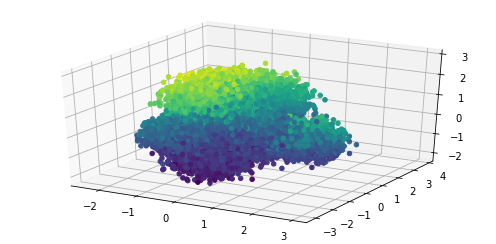

In [ ]:
pca = PCA(n_components=3, whiten=True) 
X_pca = pca.fit_transform(item_embeddings)

plt.rcParams["figure.figsize"] = [7.00, 3.50]
plt.rcParams["figure.autolayout"] = True
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
z, x, y = X_pca[:,0], X_pca[:,1], X_pca[:,2]
ax.scatter(x, y, z, c=z, alpha=1)
plt.show()

In [ ]:
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(item_embeddings)

plt.rcParams["figure.figsize"] = [15.00, 7.0]
plt.rcParams["figure.autolayout"] = True
fig = plt.figure()
plt.scatter(X_pca[:,0], X_pca[:,1], marker='.', c='fuchsia')
plt.show()

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 388607 samples in 0.034s...


KeyboardInterrupt: ignored

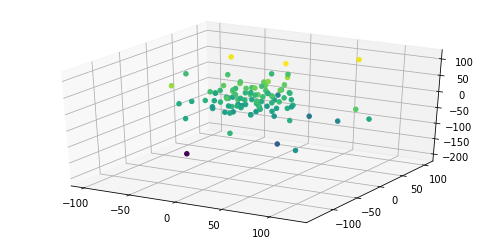

In [ ]:
tsne = TSNE(n_components=3, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(item_embeddings)

plt.rcParams["figure.figsize"] = [7.00, 3.50]
plt.rcParams["figure.autolayout"] = True
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
z, x, y = tsne_results[:,0], tsne_results[:,1], tsne_results[:,2]
ax.scatter(x, y, z, c=z, alpha=1)
plt.show()